In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 데이터 불러오기

In [40]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [41]:
train = pd.read_csv("/content/drive/MyDrive/skt/data/LSTM 예측/train.csv")
test = pd.read_csv("/content/drive/MyDrive/skt/data/LSTM 예측/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/skt/data/LSTM 예측/sample_submission.csv")
building_info = pd.read_csv("/content/drive/MyDrive/skt/data/LSTM 예측/building_info.csv")

- ESS저장용량
  - 공공기관은 전력피크 저감 등을 위해 계약전력 1,000kW이상의 건축물에 계약전력 5% 이상 규모의 에너지저장장치(ESS)를 설치하여야 한다
  - 피크 저감용 ESS : 전력요금이 저렴한 시간에 ESS전력을 저장하고, 전력요금이 높은 시간(경부하, 중간부하, 최대부하)에 저장된 전력을 방전하여 높은 Peak 시간대의 부하를 ESS 사용을 통해 요금을 낮추는 시스템.

- ESS 에너지 저장 장치 설치 규정 관련
 - https://m.blog.naver.com/bioroid/221264473739
  - 공공기관 은 전력피크 저감 등을 위해 계약전력 1,000[kW]이상의 건축물에 계약전력 5[%] 이상
규모의 에너지저장장치(ESS) 를 설치하여야 합니다.



In [42]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [43]:
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [44]:
train.shape

(204000, 10)

In [45]:
test.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


## 건물 번호를 기준으로 train set에 건물 정보 붙이기

In [46]:
import pandas as pd

# Assuming your DataFrames are named 'building_info' and 'train'
# Merge the two DataFrames on the '건물번호' column
merged_data = pd.merge(train, building_info, on='건물번호')

# Display the first few rows of the merged DataFrame
merged_data.head()


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.0,39570.0,-,-,-
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.0,39570.0,-,-,-
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.0,39570.0,-,-,-
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.0,39570.0,-,-,-
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.0,39570.0,-,-,-


In [47]:
merged_data.shape

(204000, 16)

## 결측치 확인 및 처리

In [48]:
merged_data.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
건물유형                  0
연면적(m2)               0
냉방면적(m2)              0
태양광용량(kW)             0
ESS저장용량(kWh)          0
PCS용량(kW)             0
dtype: int64

In [49]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  건물유형           204000 non-null  object 
 11  연면적(m2)        204000 non-null  float64
 12  냉방면적(m2)       204000 non-null  float64
 13  태양광용량(kW)      204000 non-null  object 
 14  ESS저장용량(kWh)   204000 non-null  object 
 15  PCS용량(kW)      204000 non-null  object 
dtypes: float64(9), int64(1), object(6)
memory usage: 26.5+ MB


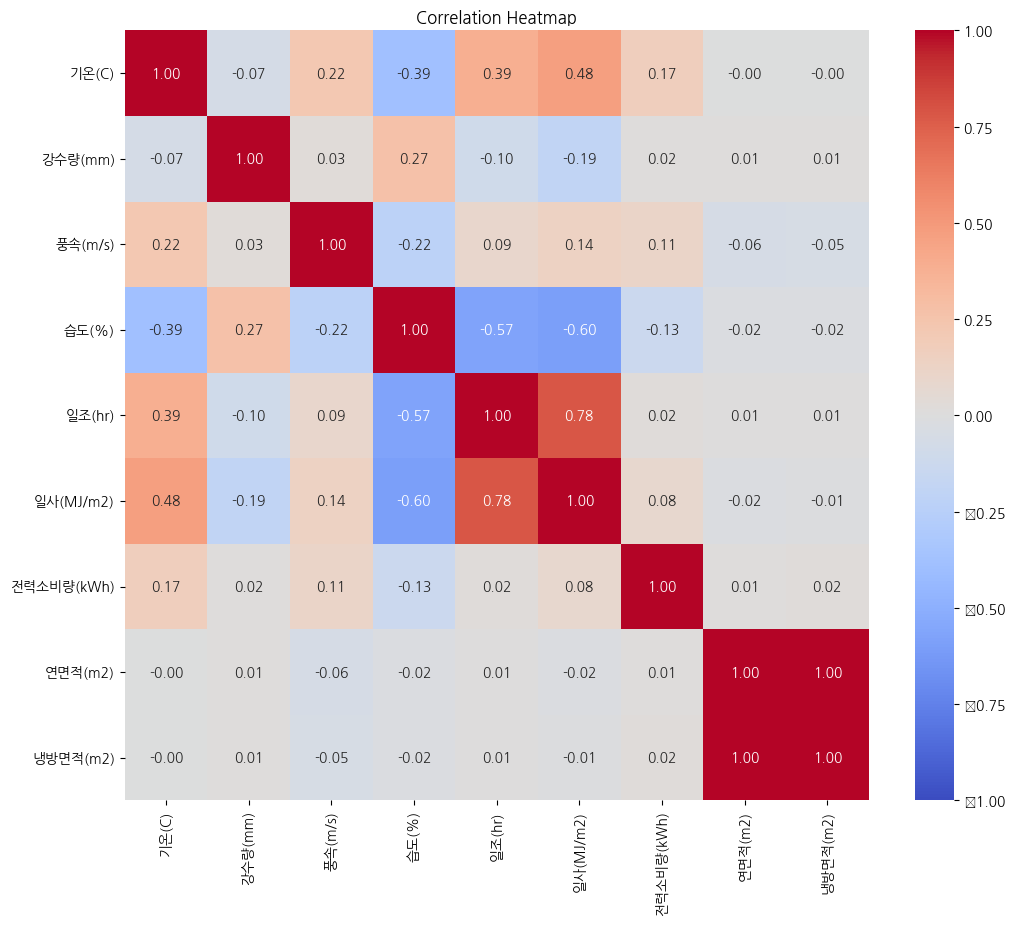

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract numerical columns
numeric_columns = ['기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']

# Create a correlation matrix
correlation_matrix = merged_data[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [51]:
merged_data.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연면적(m2),냉방면적(m2)
count,204000.000000,204000.000000,43931.000000,203981.000000,203991.000000,128818.000000,116087.000000,204000.000000,2.040000e+05,2.040000e+05
mean,50.500000,25.543524,2.040830,2.134031,78.716295,0.333637,1.063823,2451.036462,2.608875e+05,1.864032e+05
std,28.866141,3.779523,5.165218,1.358109,15.080108,0.401486,1.001030,2440.648858,1.273550e+06,1.085174e+06
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,5.578400e+03,0.000000e+00
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000,6.144612e+04,2.318700e+04
50%,50.500000,25.700000,0.100000,2.000000,81.000000,0.100000,0.710000,1766.400000,9.264050e+04,5.582336e+04
75%,75.250000,28.100000,1.300000,2.800000,91.000000,0.700000,1.780000,2970.000000,1.848135e+05,9.915097e+04
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000,1.287288e+07,1.094194e+07


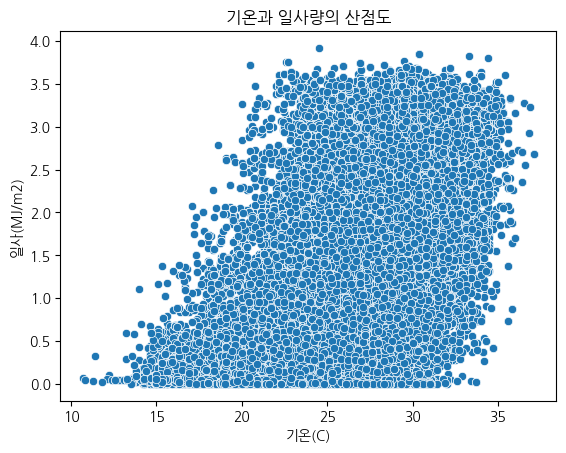

In [52]:
# 1. '일사(MJ/m2)'과 '기온(C)' 간의 관계 확인
sns.scatterplot(x='기온(C)', y='일사(MJ/m2)', data=merged_data)
plt.title('기온과 일사량의 산점도')
plt.show()

- 기온 1개로 일사를 커버 가능할 것 같음


In [53]:
# Assuming your DataFrame is named 'merged_data'

# Drop columns '강수량(mm)', '일조(hr)', '일사(MJ/m2)'
merged_data = merged_data.drop(['강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1)

# Drop rows with missing values in any column
merged_data = merged_data.dropna()

# Interpolate missing values in '풍속(m/s)' and '습도(%)'
merged_data['풍속(m/s)'] = merged_data['풍속(m/s)'].interpolate(method='linear')
merged_data['습도(%)'] = merged_data['습도(%)'].interpolate(method='linear')

# Check the updated DataFrame
print(merged_data.isnull().sum())


num_date_time    0
건물번호             0
일시               0
기온(C)            0
풍속(m/s)          0
습도(%)            0
전력소비량(kWh)       0
건물유형             0
연면적(m2)          0
냉방면적(m2)         0
태양광용량(kW)        0
ESS저장용량(kWh)     0
PCS용량(kW)        0
dtype: int64


In [54]:
merged_data.head()

,num_date_time,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20220601 00,1,20220601 00,18.6,0.9,42.0,1085.28,건물기타,110634.0,39570.0,-,-,-
1,1_20220601 01,1,20220601 01,18.0,1.1,45.0,1047.36,건물기타,110634.0,39570.0,-,-,-
2,1_20220601 02,1,20220601 02,17.7,1.5,45.0,974.88,건물기타,110634.0,39570.0,-,-,-
3,1_20220601 03,1,20220601 03,16.7,1.4,48.0,953.76,건물기타,110634.0,39570.0,-,-,-
4,1_20220601 04,1,20220601 04,18.4,2.8,43.0,986.40,건물기타,110634.0,39570.0,-,-,-


In [55]:
# Assuming your DataFrame is named 'merged_data'

# Print unique values in the '건물 유형' column
unique_building_types = merged_data['건물유형'].unique()
print("Unique Building Types:", unique_building_types)


Unique Building Types: ['건물기타' '공공' '대학교' '데이터센터' '백화점및아울렛' '병원' '상용' '아파트' '연구소' '지식산업센터' '할인마트'
 '호텔및리조트']


In [56]:
# Assuming your DataFrame is named 'merged_data'

# Drop columns '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'
merged_data = merged_data.drop(['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1)

# Check the updated DataFrame
print(merged_data.head())


   num_date_time  건물번호           일시  기온(C)  풍속(m/s)  습도(%)  전력소비량(kWh)  건물유형  \
0  1_20220601 00     1  20220601 00   18.6      0.9   42.0     1085.28  건물기타   
1  1_20220601 01     1  20220601 01   18.0      1.1   45.0     1047.36  건물기타   
2  1_20220601 02     1  20220601 02   17.7      1.5   45.0      974.88  건물기타   
3  1_20220601 03     1  20220601 03   16.7      1.4   48.0      953.76  건물기타   
4  1_20220601 04     1  20220601 04   18.4      2.8   43.0      986.40  건물기타   

    연면적(m2)  냉방면적(m2)  
0  110634.0   39570.0  
1  110634.0   39570.0  
2  110634.0   39570.0  
3  110634.0   39570.0  
4  110634.0   39570.0  


## 원핫 인코딩

In [58]:
# Assuming your DataFrame is named 'merged_data'

# Perform one-hot encoding on the '건물 유형' column
merged_data_encoded = pd.get_dummies(merged_data, columns=['건물유형'])

# Check the updated DataFrame
merged_data_encoded.head()


,num_date_time,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),연면적(m2),냉방면적(m2),건물유형_건물기타,...,건물유형_대학교,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트
0,1_20220601 00,1,20220601 00,18.6,0.9,42.0,1085.28,110634.0,39570.0,1,...,0,0,0,0,0,0,0,0,0,0
1,1_20220601 01,1,20220601 01,18.0,1.1,45.0,1047.36,110634.0,39570.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1_20220601 02,1,20220601 02,17.7,1.5,45.0,974.88,110634.0,39570.0,1,...,0,0,0,0,0,0,0,0,0,0
3,1_20220601 03,1,20220601 03,16.7,1.4,48.0,953.76,110634.0,39570.0,1,...,0,0,0,0,0,0,0,0,0,0
4,1_20220601 04,1,20220601 04,18.4,2.8,43.0,986.40,110634.0,39570.0,1,...,0,0,0,0,0,0,0,0,0,0


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming your DataFrame is named 'merged_data_encoded'

# Define features (X) and target variable (y)
features = merged_data_encoded.drop(['num_date_time', '건물번호', '일시', '전력소비량(kWh)'], axis=1)
target = merged_data_encoded['전력소비량(kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')


Mean Squared Error (MSE): 4175275.3207883122
Root Mean Squared Error (RMSE): 2043.3490452657159
R-squared (R2): 0.2995450441748154
